In [1]:
# importing required packages
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load('en')

from spacy import displacy
#from spacy.lang.en import English
#parser = English()

#from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin 

#from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV


from scipy.sparse import csr_matrix

np.random.seed(42)
%matplotlib inline

In [ ]:
# set up display area to show dataframe in jupyter qtconsole

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', 1000)

pd.set_option('display.max_colwidth', -1)

In [2]:
myDir = Path.cwd().parents[0]
dataFolder = myDir / 'data/asap-sas'
ratingsFolder = myDir / 'data/ratings'

print(dataFolder)

C:\Users\Devanshi\Desktop\finalProject\data\asap-sas


In [4]:
df = pd.read_csv(dataFolder/'training.csv', header=0)  #read data into dataframe
df.head(2)


,EssaySet,subject,studentGrade,EssayText,Score1,styleScore,totalChars,total_words,words_no_punct,words_no_punct_no_stop,count_content_words,count_stopwords,avg_word_len,maturity,concreteness,content_only_text,function_based_text,function_only_text,pos_tags
0,7,English,10,One trait that describes rose is hard-working....,1,1,120,27,23,12,15,11,4.173913,5.487419,2.449177,trait that describes rose is hard working...,one __NOUN__ __ADJ__ __VERB__ __VERB__ __VERB_...,"One - . I this because she to , but sh...",NUM NOUN ADJ VERB VERB VERB ADV PUNCT VERB PUN...
1,9,English,10,First the author has an introduction to grab t...,1,1,190,38,33,18,20,15,4.666667,5.333607,2.461765,First author has introduction grab reader...,__ADV__ the __NOUN__ __VERB__ an __NOUN__ to _...,"the an to the 's . , the if in the ...",ADV DET NOUN VERB DET NOUN PART VERB DET NOUN ...


In [7]:
# Take only essay set 1
set_1 = df[(df['EssaySet'] == 1)].copy()
set_1.shape

(1339, 19)

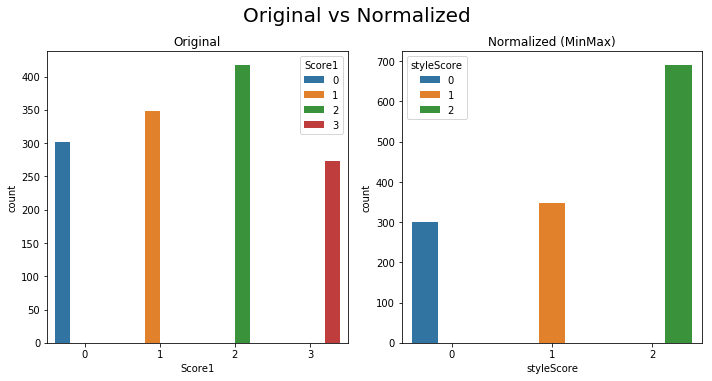

In [6]:
f, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(10,5), )

sns.countplot(x="Score1", data=set_1, orient='v', hue="Score1", ax=ax1)
sns.countplot(x="styleScore", data=set_1, orient='v', hue="styleScore", ax=ax2)

#Customise title
plt.suptitle("Original vs Normalized", y = 1.05, fontsize=20)
ax1.set_title("Original",  y = 1)
ax2.set_title("Normalized (MinMax)", y = 1)
plt.tight_layout()

In [70]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score
#from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline


In [79]:
skf = StratifiedKFold(n_splits=5, random_state=42)

X = set_1[['EssayText','Score1']].copy()
X.reset_index(drop=True,inplace=True)
y= X.pop('Score1')

print(X.shape, y.shape)

(1339, 1) (1339,)


In [80]:
#Initialise vectoriser
count_vectorizer = CountVectorizer()
clf = LogisticRegression()
target_names = [str(i) for i in sorted(y.unique())] #Convert to string


# data is an array with our already pre-processed dataset examples
for train_index, test_index in skf.split(X, y):
    
    print("Train:", len(train_index), "Test:", len(test_index))
    X_train, X_test = X.reindex(train_index), X.reindex(test_index)
    y_train, y_test = y.reindex(train_index), y.reindex(test_index)
    
    #Make pipeline to train classifier
    pipe = make_pipeline(count_vectorizer, clf)
    pipe.fit(X_train['EssayText'], y_train)
    
    #Make predictions on test data
    y_pred = pipe.predict(X_test['EssayText'])
    
    print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
    print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
    print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
    print(cohen_kappa_score(y_test, y_pred))


Train: 1069 Test: 270
(0.607979797979798, 0.6100445319707615, 0.6044697165276098, None)
(0.6074074074074074, 0.6074074074074074, 0.6074074074074074, None)
(0.6022334455667789, 0.6074074074074074, 0.5999404787516314, None)
0.4703236910776747
Train: 1070 Test: 269
(0.5598441152946967, 0.5481060606060606, 0.551594746716698, None)
(0.5427509293680297, 0.5427509293680297, 0.5427509293680297, None)
(0.5500850805726746, 0.5427509293680297, 0.5440947060314183, None)
0.38369407294266666
Train: 1071 Test: 268
(0.6161849143358865, 0.6061205862410681, 0.6020678910186769, None)
(0.6007462686567164, 0.6007462686567164, 0.6007462686567164, None)
(0.6030185605435546, 0.6007462686567164, 0.5918339114557791, None)
0.45949410035058624
Train: 1073 Test: 266
(0.5660348758709415, 0.5756276312981394, 0.5699189464923526, None)
(0.5639097744360902, 0.5639097744360902, 0.5639097744360902, None)
(0.5610522186634598, 0.5639097744360902, 0.5616281798039836, None)
0.41567246146271264
Train: 1073 Test: 266
(0.545103

In [83]:
X = set_1[['function_based_text','Score1']].copy()
X.reset_index(drop=True,inplace=True)
y= X.pop('Score1')

print(X.shape, y.shape)

#Initialise vectoriser
count_vectorizer = CountVectorizer()
clf = LogisticRegression() #OvR classifier
target_names = [str(i) for i in sorted(y.unique())] #Convert to string


# data is an array with our already pre-processed dataset examples
for train_index, test_index in skf.split(X, y):
    
    print("Train:", len(train_index), "Test:", len(test_index))
    X_train, X_test = X.reindex(train_index), X.reindex(test_index)
    y_train, y_test = y.reindex(train_index), y.reindex(test_index)
    
    #Make pipeline to train classifier
    pipe = make_pipeline(count_vectorizer, clf)
    pipe.fit(X_train['function_based_text'], y_train)
    
    #Make predictions on test data
    y_pred = pipe.predict(X_test['function_based_text'])
    
    print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
    print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
    print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
    print(cohen_kappa_score(y_test, y_pred))



(1339, 1) (1339,)
Train: 1069 Test: 270
(0.4535262298428251, 0.4392591015541835, 0.4329341058694658, None)
(0.44814814814814813, 0.44814814814814813, 0.44814814814814813, None)
(0.44540888919129373, 0.44814814814814813, 0.43417279772617495, None)
0.24774210437741917
Train: 1070 Test: 269
(0.3831232492997199, 0.3890151515151515, 0.38478021978021976, None)
(0.3940520446096654, 0.3940520446096654, 0.3940520446096654, None)
(0.386872221007362, 0.3940520446096654, 0.3891923689693206, None)
0.1832845940358001
Train: 1071 Test: 268
(0.42422500425821835, 0.41681792103478854, 0.4096899819898355, None)
(0.4291044776119403, 0.4291044776119403, 0.4291044776119403, None)
(0.4235424182104297, 0.4291044776119403, 0.4164891921006229, None)
0.2258283772302463
Train: 1073 Test: 266
(0.4558498399359744, 0.46317904468114, 0.4547386851944863, None)
(0.46616541353383456, 0.46616541353383456, 0.46616541353383456, None)
(0.45407817262243244, 0.46616541353383456, 0.45534104598512853, None)
0.27851317020992117


In [6]:
#Initialise vectoriser
count_vectorizer = CountVectorizer()
clf = LogisticRegression() #OvR classifier
target_names = [str(i) for i in sorted(y.unique())] #Convert to string


# data is an array with our already pre-processed dataset examples
for train_index, test_index in skf.split(X, y):
    
    print("Train:", len(train_index), "Test:", len(test_index))
    X_train, X_test = X.reindex(train_index), X.reindex(test_index)
    y_train, y_test = y.reindex(train_index), y.reindex(test_index)
    
    #Make pipeline to train classifier
    pipe = make_pipeline(count_vectorizer, clf)
    pipe.fit(X_train['EssayText'], y_train)
    
    #Make predictions on test data
    y_pred = pipe.predict(X_test['EssayText'])
    
    print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
    print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
    print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
    print(cohen_kappa_score(y_test, y_pred))

## Feature Extraction

### Get Features
* custom features

* N-grams (words)

* n-grams (POS)

### Concatenate Features & Prepare X & Y 

### Prepare X & Y data

In [ ]:
X_train = pd.SparseDataFrame(data=merged_2, columns=feature_names)
X_train.head()

#X_train = csr_matrix(merged_2) 
# X_train

In [210]:
#y_train_tmp = pd.DataFrame(y_train_tmp)
# y_train_scaled = StandardScaler().fit_transform(y_train_tmp.astype(float))
# y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train_tmp.index, columns=['Score1'])
# y_train = np.squeeze(y_train_scaled)


y_train = y_train_tmp

#print(X_train.shape)
print(y_train.shape)

(1170,)


In [211]:
print(text_ngrams_df.shape)

(1170, 264)


# CLASSIFICATION
## Feature Selection

In [7]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif
#from sklearn.linear_model import Lasso
#from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline


import eli5
from eli5.lime import TextExplainer

from yellowbrick.features.importances import FeatureImportances

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Univariate Selection
* Mutual Information

In [214]:
kBestmodel = SelectKBest(mutual_info_classif, k='all')
fit_data = kBestmodel.fit(text_ngrams_df, y_train)

In [222]:
feature_importance = list(zip(text_ngrams_columns, fit_data.scores_))
kBest_feature_importance = pd.DataFrame(feature_importance, columns=['feature','kBest_weight'])
kBest_feature_importance.sort_values(by='kBest_weight', ascending=False).head()

,feature,kBest_weight
108,__VERB__,0.087464
106,__NOUN__,0.078108
238,to,0.070309
105,__ADV__,0.057497
191,of,0.052992


In [224]:
kBest_feature_importance.sort_values(by='kBest_weight').head(10)

,feature,kBest_weight
263,zero,0.0
176,inside,0.0
178,it,0.0
92,8,0.0
181,materialinto,0.0
182,me,0.0
87,60minsand,0.0
188,no,0.0
84,5,0.0
83,4s,0.0


## 1) Baseline Model
* Logitistic Regression

In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [19]:
def print_report(pipe, X, y, target_names):
    y_test = y
    y_pred = pipe.predict(X)
    report = metrics.classification_report(y_test, y_pred, target_names=target_names)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

In [30]:
# We’re using LogisticRegressionCV here to adjust regularization parameter C automatically. 
# It allows to compare different vectorizers - optimal C value could be different for different input features 
# (e.g. for bigrams or for character-level input).
# An alternative would be to use GridSearchCV or RandomizedSearchCV.


#Initialise vectoriser
count_vectorizer = CountVectorizer()
clf = LogisticRegressionCV()
target_names = [str(i) for i in sorted(y_train_tmp.unique())] #Convert to string

pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train_tmp)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [31]:
print_report(pipe,train['EssayText'], y_train_tmp, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.74      0.95      0.83       268
          1       0.94      0.43      0.59       309
          2       0.84      0.97      0.90       593

avg / total       0.84      0.82      0.80      1170

accuracy: 0.824
             precision    recall  f1-score   support

          0       0.79      0.89      0.84       112
          1       0.71      0.30      0.42       120
          2       0.78      0.94      0.85       270

avg / total       0.76      0.77      0.75       502

accuracy: 0.775


In [32]:
#Intercept (bias) feature is shown as <BIAS> in the same table. 
#We can inspect features and weights because we’re using a bag-of-words vectorizer and a linear classifier
#(so there is a direct mapping between individual words and classifier coefficients)

#eli5.show_weights(clf, top=10)
eli5.show_weights(clf, vec=count_vectorizer, top=15,  target_names=target_names)

In [33]:
eli5.show_prediction(clf, test['EssayText'][438], vec=count_vectorizer, target_names=target_names)

## Naive Bayes

In [53]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [285]:

# def test_print_report(pipe):
#     y_test = y_test_tmp
#     y_pred = pipe.predict(test['EssayText'])
#     report = metrics.classification_report(y_test, y_pred,
#         target_names=target_names)
#     print(report)
#     print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))


In [55]:
#Initialise vectoriser
clf = MultinomialNB()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train_tmp);
#MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
print_report(pipe,train['EssayText'], y_train_tmp, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.97      0.75      0.84       268
          1       0.81      0.58      0.68       309
          2       0.78      0.97      0.87       593

avg / total       0.83      0.82      0.81      1170

accuracy: 0.819
             precision    recall  f1-score   support

          0       0.86      0.50      0.63       112
          1       0.42      0.23      0.30       120
          2       0.70      0.96      0.81       270

avg / total       0.67      0.68      0.65       502

accuracy: 0.681


In [58]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label, " ".join(feature_names[j] for j in top10)))

In [59]:
print_top10(count_vectorizer, clf, target_names)

0: experiment in would need mass of you and to the
1: and experiment how you in need would of to the
2: what vinegar know how in need would of to the


In [64]:
# It means that higher values mean more important features for the positive class.
# The above print shows the top 20 lowest values (less predictive features) in the first column 
#and the top 20 high values (highest predictive features) in the second column.

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vectorizer, clf, n=20)

	-9.2963	100            		-2.6005	the            
	-9.2963	100g           		-3.1849	to             
	-9.2963	100ml          		-3.7590	and            
	-9.2963	10cm           		-3.8847	you            
	-9.2963	10g            		-3.8847	of             
	-9.2963	11grams        		-3.9118	mass           
	-9.2963	1day           		-3.9350	need           
	-9.2963	1st            		-3.9980	would          
	-9.2963	1telling       		-4.0285	in             
	-9.2963	2days          		-4.2725	experiment     
	-9.2963	30min          		-4.4923	samples        
	-9.2963	3rd            		-4.5601	they           
	-9.2963	50g            		-4.6142	it             
	-9.2963	6th            		-4.6424	is             
	-9.2963	7grams         		-4.7320	for            
	-9.2963	above          		-4.7530	what           
	-9.2963	absolutely     		-4.7745	sample         
	-9.2963	absorb         		-4.7965	each           
	-9.2963	absorbed       		-4.8304	information    
	-9.2963	accuracy       		-4.8420	this           


In [284]:
#Initialise vectoriser
clf = BernoulliNB()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train);
#MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [286]:
print_report(pipe,train['EssayText'], y_train, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.65      0.61      0.63       268
          1       0.53      0.27      0.36       309
          2       0.68      0.86      0.76       593

avg / total       0.63      0.65      0.62      1170

accuracy: 0.649


             precision    recall  f1-score   support

          0       0.63      0.55      0.59       112
          1       0.41      0.16      0.23       120
          2       0.65      0.86      0.74       270

avg / total       0.59      0.63      0.59       502

accuracy: 0.625


## SVM

In [297]:
from sklearn.svm import SVC

In [66]:
#clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf = SVC(kernel='linear', probability=True)
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train_tmp)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [67]:
print_report(pipe,train['EssayText'], y_train_tmp, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.96      1.00      0.98       268
          1       0.99      0.97      0.98       309
          2       0.99      0.98      0.98       593

avg / total       0.98      0.98      0.98      1170

accuracy: 0.982
             precision    recall  f1-score   support

          0       0.71      0.71      0.71       112
          1       0.46      0.49      0.48       120
          2       0.81      0.79      0.80       270

avg / total       0.70      0.70      0.70       502

accuracy: 0.699


In [68]:
te = TextExplainer(random_state=42)
te.fit(test['EssayText'][438], pipe.predict_proba)
te.show_prediction(target_names=target_names)

In [294]:
from sklearn.ensemble import RandomForestClassifier

In [295]:
clf = RandomForestClassifier()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train)

print_report(pipe,train['EssayText'], y_train, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       268
          1       1.00      0.97      0.99       309
          2       0.99      1.00      0.99       593

avg / total       0.99      0.99      0.99      1170

accuracy: 0.991
             precision    recall  f1-score   support

          0       0.67      0.49      0.57       112
          1       0.24      0.20      0.22       120
          2       0.66      0.79      0.72       270

avg / total       0.56      0.58      0.56       502

accuracy: 0.580


In [296]:
eli5.show_weights(clf, vec=count_vectorizer, top=15,  target_names=target_names)

Weight,Feature
0.0732 ± 0.0558,__VERB__
0.0551 ± 0.0457,__ADV__
0.0512 ± 0.0356,__NOUN__
0.0501 ± 0.0396,to
0.0410 ± 0.0193,__ADJ__
0.0385 ± 0.0211,the
0.0374 ± 0.0178,of
0.0339 ± 0.0179,each
0.0319 ± 0.0210,in
0.0287 ± 0.0173,.


In [ ]:
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [ ]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_train, y_train)



In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### Tree Based 
* Random Forests
* GradientBoosted Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold



rf_features = RFECV(RandomForestClassifier(n_estimators=100), cv=StratifiedKFold(5), scoring='f1_weighted')
rf_features.fit(X_train, y_train)
rf_features.poof()

In [ ]:
# Create a new matplotlib figure
# fig = plt.figure()
# ax = fig.add_subplot()

gb_model = GradientBoostingClassifier().fit(X_train, y_train)
feature_importances = gb_model.feature_importances_

eli5.show_weights(gb_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

In [ ]:
clf = SVC(C=150, gamma=2e-2, probability=True)

pipe = make_pipeline(clf)
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

In [ ]:
y_train.values

In [ ]:
dict(y_train.values)

In [ ]:
def print_prediction(doc):
    y_pred = pipe.predict_proba([doc])[0]
    #print(y_pred)
    for target, prob in zip(y_train, y_pred):
        print("{:.3f} {}".format(prob, target))

doc = X_train.loc[0,]
print_prediction(doc)

In [ ]:
# sparse_df = pd.SparseDataFrame(X_train)
# sparse_df.head()

sparse_df.fillna(0,inplace=True)
sparse_df.loc[0,].shape

In [ ]:
te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)
te.show_prediction(target_names=twenty_train.target_names)

In [ ]:
eli5.show_prediction(gb_model, doc=train.iloc[1145,0], ve)

In [ ]:
# def get_rmsle(y_true, y_pred):
#     return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

cv = KFold(n_splits=10, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train):
    model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)
    model.fit(X_train[train_ids], y_train[train_ids])
    y_pred_valid = model.predict(X_train[valid_ids])
    rmsle = mean_squared_error(y_test, y_pred)
    print(f'valid rmsle: {rmsle:.5f}')
    break


linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))